In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras import metrics
from keras.models import Model
from PIL import Image
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from scipy.ndimage.filters import gaussian_filter

from vgg16_avg import VGG16_Avg

Using TensorFlow backend.


In [100]:
%qtconsole

In [2]:
%matplotlib inline

### Setup vgg processing functions

In [4]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [4]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [5]:
def solve_image(eval_obj, niter, x, shp):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(
            eval_obj.loss, 
            x.flatten(),
            fprime=eval_obj.grads, 
            maxfun=20
        )
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave('results/res_at_iteration_{}.png'.format(i), deproc(x.copy(), shp)[0])
    return x

In [6]:
rand_img_100 = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
rand_img_1 = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1

In [7]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [8]:
def style_loss(x, targ): return metrics.mse(gram_matrix(x), gram_matrix(targ))

### Load content image

In [2]:
content_img = Image.open('suicide-girl-2.jpg')

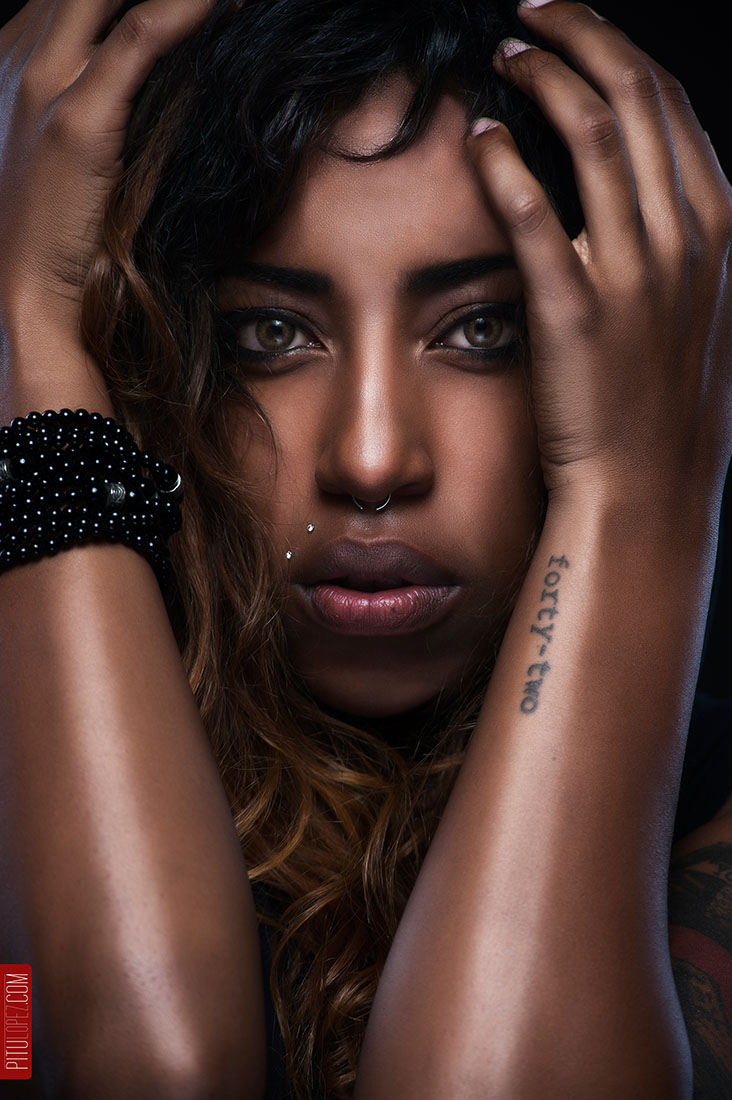

In [3]:
content_img

In [6]:
content_arr = preproc(np.expand_dims(np.array(content_img), 0))

In [7]:
content_shape = content_arr.shape

In [8]:
content_shape

(1, 1100, 732, 3)

### Setup VGG model

In [10]:
model = VGG16_Avg(include_top=False)

In [49]:
layer = model.get_layer('block4_conv1').output

In [50]:
layer_model = Model(model.input, layer)
target = K.variable(layer_model.predict(content_img_arr))

In [52]:
loss = metrics.mse(layer, target)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, content_shape)

### Content recreation

start with a random image

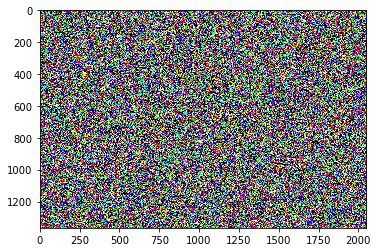

In [54]:
x = rand_img(content_shape)
plt.imshow(x[0])
# Image.fromarray(x)

In [55]:
iterations = 10

In [56]:
x = solve_image(evaluator, iterations, x)

Current loss value: 1684.59716797
Current loss value: 778.882263184
Current loss value: 562.47845459
Current loss value: 458.394958496
Current loss value: 399.147766113
Current loss value: 360.267456055
Current loss value: 335.558013916
Current loss value: 313.701904297
Current loss value: 298.360168457
Current loss value: 286.400177002


### Style recreation

In [81]:
output_shape = (730, 1100)

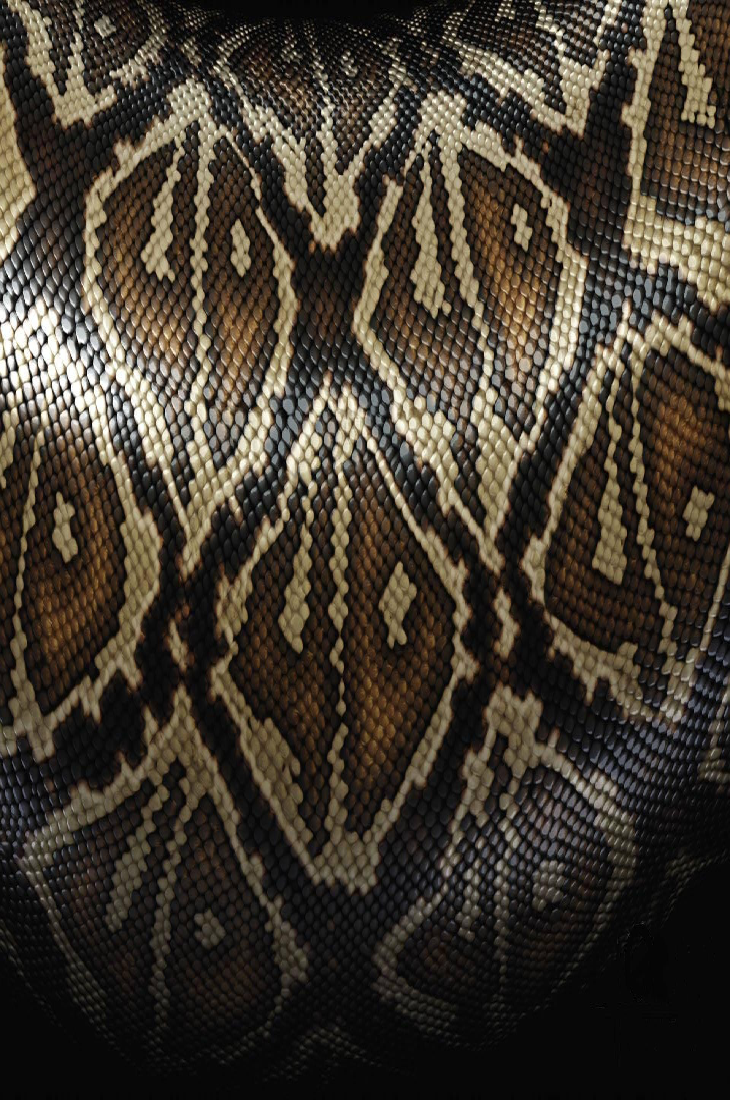

In [103]:
style_img = Image.open('snake.jpg')
style_img = style_img.resize(output_shape)
style_img

In [104]:
style_arr = preproc(np.expand_dims(style_img, 0)[:,:,:,:3])
style_shape = style_arr.shape

In [105]:
model = VGG16_Avg(include_top=False, input_shape=style_shape[1:])
outputs = {l.name: l.output for l in model.layers}

In [106]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]

In [107]:
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

In [108]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, style_shape)

In [109]:
x = rand_img_1(style_shape)
x = gaussian_filter(x, [0,2,2,0])

In [110]:
iterations = 10
x = rand_img_1(style_shape)

In [111]:
x = solve_image(evaluator, iterations, x, style_shape)

Current loss value: 7835.22705078
Current loss value: 1306.91625977
Current loss value: 263.103515625
Current loss value: 66.1873321533
Current loss value: 30.9253578186
Current loss value: 17.3311977386
Current loss value: 12.8494882584
Current loss value: 9.58259391785
Current loss value: 7.61048269272
Current loss value: 6.2898888588


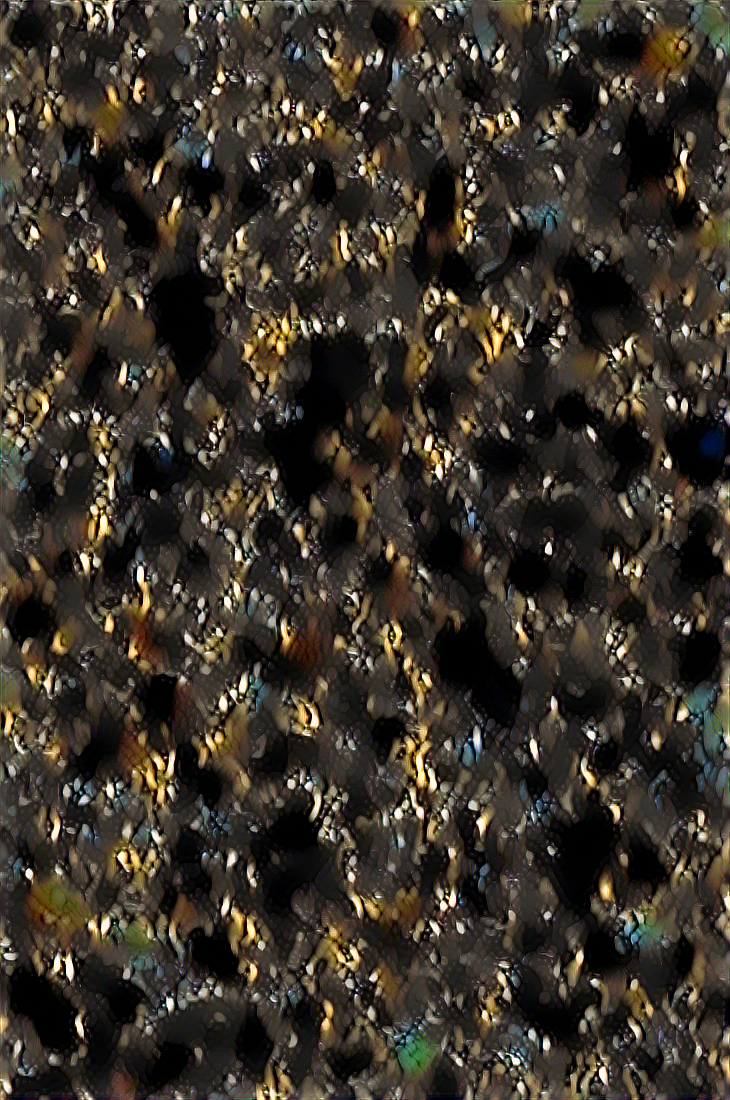

In [112]:
Image.open('results/res_at_iteration_9.png')

### Style Transfer

In [139]:
style_shape

(1, 600, 800, 3)

In [140]:
content_shape

(1, 666, 1000, 3)

In [82]:
output_shape = (800, 600)

In [113]:
content_img = content_img.resize(output_shape)

In [114]:
content_arr = preproc(np.expand_dims(np.array(content_img), 0))

In [115]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

In [116]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [117]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(content_arr))

In [118]:
# style_wgts = [0.05, 0.2, 0.2, 0.25, 0.3]
style_wgts = [0.02, 0.1, 0.1, 0.15, 0.15]

In [119]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2,w in zip(style_layers, style_targs, style_wgts))
loss += metrics.mse(content_layer, content_targ)/10
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [120]:
evaluator = Evaluator(transfer_fn, style_shape)

In [121]:
iterations = 20
x = rand_img_100(style_shape)

In [122]:
x = solve_image(evaluator, iterations, x, style_shape)

Current loss value: 4463.67041016
Current loss value: 1877.16357422
Current loss value: 733.488342285
Current loss value: 477.39163208
Current loss value: 371.541778564
Current loss value: 328.609405518
Current loss value: 302.417602539
Current loss value: 285.335021973
Current loss value: 270.339935303
Current loss value: 259.360473633
Current loss value: 249.941131592
Current loss value: 242.191558838
Current loss value: 236.005584717
Current loss value: 229.833068848
Current loss value: 224.302612305
Current loss value: 219.576980591
Current loss value: 215.522720337
Current loss value: 212.335708618
Current loss value: 208.967727661
Current loss value: 205.778839111
